# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-I,no-book-author,11350,20420
1,BX-I,male,100909,461912
2,BX-I,no-author-rec,10622,17233
3,BX-I,no-book,40633,56245
4,BX-I,female,69784,398122


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,239422.0,536270.0,22301.0,238677.0,126702.0,113652.0,985503.0,2262527.0
BX-E,39587.0,57701.0,5202.0,15724.0,5273.0,5613.0,20075.0,149175.0
BX-I,69784.0,100909.0,8922.0,32389.0,10622.0,11350.0,40633.0,274609.0
GR-E,215677.0,319931.0,16817.0,102652.0,42740.0,787097.0,NaN,1484914.0
GR-I,217770.0,323939.0,16990.0,104424.0,43559.0,799783.0,NaN,1506465.0
LOC-MDS,739018.0,2414635.0,70919.0,1136753.0,263810.0,609387.0,NaN,5234522.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4778691.0,6914064.0,803800.0,2087659.0,779306.0,1278813.0,5798466.0
BX-E,141196.0,181892.0,41534.0,25218.0,6671.0,7614.0,23084.0
BX-I,398122.0,461912.0,103923.0,71357.0,17233.0,20420.0,56245.0
GR-E,36501620.0,33395862.0,12695595.0,3591909.0,739723.0,12294989.0,NaN
GR-I,82827808.0,69993792.0,20945491.0,10088386.0,2412556.0,33273918.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.105821,0.237023,0.009857,0.105491,0.056000,0.050232,0.435576
BX-E,0.265373,0.386801,0.034872,0.105406,0.035348,0.037627,0.134573
BX-I,0.254121,0.367464,0.032490,0.117946,0.038680,0.041331,0.147967
GR-E,0.145245,0.215454,0.011325,0.069130,0.028783,0.530062,NaN
GR-I,0.144557,0.215033,0.011278,0.069317,0.028915,0.530900,NaN
LOC-MDS,0.141182,0.461290,0.013548,0.217165,0.050398,0.116417,NaN


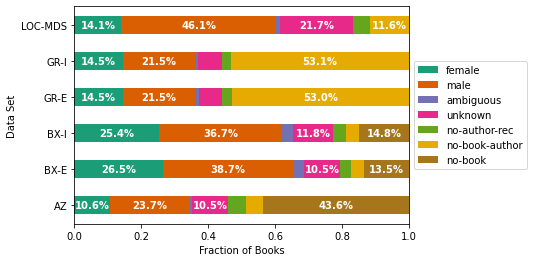

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.105821,0.237023,0.009857,0.105491,0.541809
BX-E,0.265373,0.386801,0.034872,0.105406,0.207548
BX-I,0.254121,0.367464,0.032490,0.117946,0.227979
GR-E,0.145245,0.215454,0.011325,0.069130,0.558845
GR-I,0.144557,0.215033,0.011278,0.069317,0.559815
LOC-MDS,0.141182,0.461290,0.013548,0.217165,0.166815


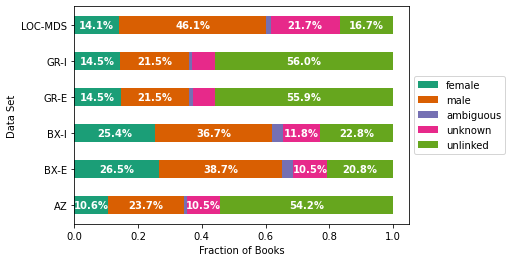

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

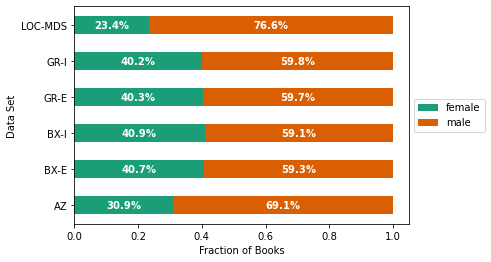

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.212947,0.308102,0.035819,0.093030,0.034727,0.056986,0.258389
BX-E,0.330508,0.425768,0.097222,0.059030,0.015615,0.017823,0.054034
BX-I,0.352566,0.409057,0.092031,0.063192,0.015261,0.018083,0.049809
GR-E,0.367887,0.336585,0.127954,0.036202,0.007455,0.123917,NaN
GR-I,0.377276,0.318817,0.095405,0.045952,0.010989,0.151561,NaN


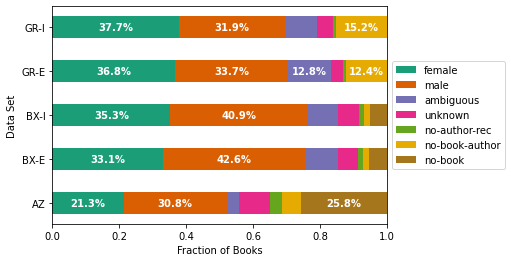

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.212947,0.308102,0.035819,0.093030,0.350103
BX-E,0.330508,0.425768,0.097222,0.059030,0.087472
BX-I,0.352566,0.409057,0.092031,0.063192,0.083154
GR-E,0.367887,0.336585,0.127954,0.036202,0.131372
GR-I,0.377276,0.318817,0.095405,0.045952,0.162550


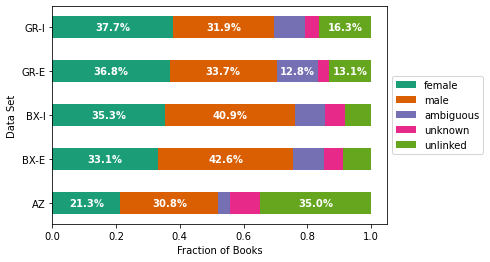

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

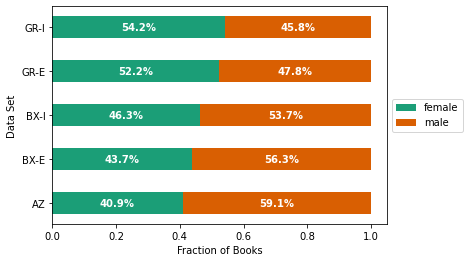

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.352700
BX-E       0.687045
BX-I       0.654075
GR-E       0.372025
GR-I       0.370868
LOC-MDS    0.616020
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')